# 0: Download Data Section

In [224]:
# Prepare for using kaggle api
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [225]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
# Download data
!pip install kaggle
!kaggle competitions download -c m5-forecasting-accuracy -p /content/drive/MyDrive/data_root/M5

calendar.csv: Skipping, found more recently modified local copy (use --force to force download)
sales_train_validation.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sell_prices.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train_evaluation.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


# 1.Prepare section

In [227]:
import os
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms

import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 256

cuda


# 2. Transform Section

In [228]:
class ComposeTransform():
    """
    複数のTransformをまとめあげる
    """
    def __init__(self, transforms=None):
        """
        Parameters
        --------------
        transforms: list
            transformのインスタンスをリストにして渡す
        """
        self.transforms = transforms

    def __call__(self, x):
        if self.transforms:
            for transform in self.transforms:
                x = transform(x)
        return x


class BaseTransform():
    """
    自作Transformの基底クラス
    """
    def __init__(self, debug=False):
        self.debug = debug
    
    def __call__(self):
        raise NotImplementedError()


class SimpleTransform(BaseTransform):
    """
    とりあえずのクラス
    よく使うものを入れておく
    扱う関数が増えてきたらテーマごとに分離する
    """
    def __init__(self, debug= False):
        super().__init__(debug)
        self.applied_transforms = [
            self.to_tensor,
            self.resize
        ]
    def __call__(self, x):
        if self.debug:
            print('------------前処理前-----------')
            print(x)
            for transform in self.applied_transforms:
                x = transform(x)
                print('------------------------')
                print(str(transform))
                print(x)
                
        else:
            for transform in self.applied_transforms:
                x = transform(x)
        return x


    def to_tensor(self, x):
        return torch.from_numpy(x).float()
    
    def resize(self, x):
        return x.view([-1, 1])

class SimpleTargetTransform(BaseTransform):
    """
    とりあえずのクラス
    ターゲットに対して行う前処理を記述するクラス
    よく使うものを入れておく
    扱う関数が増えてきたらテーマごとに分離する
    """
    def __init__(self, debug):
        super().__init__(debug)
        self.applied_transforms = [
            self.to_tensor,
            self.resize
        ]
    def __call__(self, y):
        if self.debug:
            print('-----------前処理前-------------')
            print(y)
            for transform in self.applied_transforms:
                
                y = transform(y)
                print('------------------------------')
                print(str(transform))
                print(y)
                
        else:
            for transform in self.applied_transforms:
                y = transform(y)
        return y
       
    def to_tensor(self, y):
        y = np.array(y)
        return torch.from_numpy(y).float()
    
    def resize(self, y):
        return y.view([1])

# 3. Dataset Section

In [229]:
class M5Dataset():
    def __init__(self, path, transform= None, train=True):
        self.transform = transform
        # pandasは処理が遅いのでなるべく早くnumpyへ
        self.data = pd.read_csv(path).values
        self.train = train
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.train:
            label =self.data[idx, -1]
            x = self.data[idx, :-1]
            if self.transform:
                x = self.transform(x)
            if self.target_transform:
                label = self.target_transform(label)
            return x, label
        else:
            x = self.data[idx, :]
            if self.transform:
                x = self.transform(x)
            return x

In [230]:
class SequencialDataset():
    def __init__(self, data, transform= None, target_transform=None, train=True, n_steps=28):
        self.transform = transform
        self.target_transform = target_transform
        # pandasは処理が遅いのでなるべく早くnumpyへ
        self.data = np.empty((len(data)-n_steps, n_steps))
        for i in range(len(data) - n_steps):
            self.data[i] = data[i:i+n_steps]
        self.train = train
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.train:
            label =self.data[idx, -1]
            x = self.data[idx, :-1]
            if self.transform:
                x = self.transform(x)
            if self.target_transform:
                label = self.target_transform(label)
            return x, label
        else:
            x = self.data[idx, :]
            if self.transform:
                x = self.transform(x)
            return x

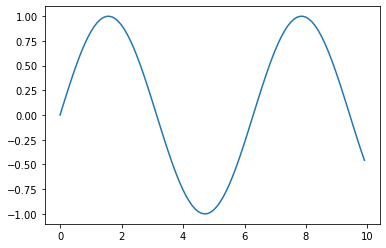

(array([0.        , 0.09983342, 0.19866933, 0.29552021, 0.38941834,
       0.47942554, 0.56464247, 0.64421769, 0.71735609, 0.78332691,
       0.84147098, 0.89120736, 0.93203909, 0.96355819, 0.98544973,
       0.99749499, 0.9995736 , 0.99166481, 0.97384763, 0.94630009,
       0.90929743, 0.86320937, 0.8084964 , 0.74570521, 0.67546318,
       0.59847214, 0.51550137]), 0.4273798802338298)


In [231]:
x = np.arange(0, 10, 0.1)
y = np.sin(x)
plt.plot(x, y)
plt.show()

dataset = SequencialDataset(data=y)
print(dataset[0])

# 4. Model Section

In [232]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=1000, output_size=1):
        super().__init__()
        self.lstm = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out)
        return predictions[:,-1,:]

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=1000, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        # LSTM のinputは(batch, )
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out)
        return predictions[:,-1,:]

# 5.Main function section

In [233]:
def train_net(net, train_loader, eval_loader, optim_cls=optim.SGD, loss_fn=nn.CrossEntropyLoss, n_iter=200, device= 'cuda:0'):
    optimizer = optim_cls(net.parameters(), lr=0.05)
    loss_fn = loss_fn()
    losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    n = 0
    n_acc = 0
    net = net.to(device)

    for epoch in range(n_iter):
        running_loss=0.0
        net.train()
        with tqdm.tqdm(train_loader) as pbar:
            for i, (x, label) in enumerate(pbar):
                x = x.to(device)
                label = label.to(device)
                h = net(x)
                loss = loss_fn(h, label)
                running_loss+=loss.item()
                n += len(label)
                _, y_pred = h.max(1)
                n_acc += (y_pred==label).float().sum().item()

                # 逆伝播によるパラメータ更新
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_postfix(OrderedDict(
                    epoch= epoch+1,
                    loss=running_loss/(i+1), 
                    ))
            losses.append(running_loss / len(train_loader))
            train_acc.append(n_acc / n)
            val_loss, val_acc_ = val_net(net, eval_loader, loss_fn)
            val_losses.append(val_loss)
            val_acc.append(val_acc_)

    return losses, val_losses, train_acc, val_acc

def val_net(net, eval_loader, loss_fn, device= 'cuda:0'):
    net.eval()
    val_acc = 0
    val_loss = 0
    n = 0
    n_acc =0
    running_loss=0.0
    net = net.to(device)
    for i, (x, label) in enumerate(val_loader):
        x = x.to(device)
        label = label.to(device)
        h = net(x)
        loss = loss_fn(h, label)
        running_loss+=loss.item()
        n += len(label)
        _, y_pred = h.max(1)
        n_acc += (y_pred==label).float().sum().item()
    val_acc = n_acc / n
    val_loss = running_loss / len(val_loader)
    return val_loss, val_acc

def pred_net(net, test_loader, device= 'cuda:0'):
    y_preds = []
    net = net.to(device)
    for i, x in enumerate(test_loader):
        x = x.to(device)
        h = net(x)
        _, y_pred = h.max(1)
        y_preds.append(y_pred)
    return torch.cat(y_preds,dim=0)

# 6. Train Section

In [234]:
# Transform組み立て
transform = ComposeTransform([
    SimpleTransform(debug=False)
    ])
target_transform = ComposeTransform([
    SimpleTargetTransform(debug=False)
    ])
# Dataset組み立て
dataset = SequencialDataset(data=y, transform=transform, target_transform= target_transform)
#dataset = M5Dataset('/content/drive/MyDrive/data_root/M5/sales_train_validation.csv.zip', transform=transform)
train_size = int(len(dataset)*0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#実験

# Dataloader組み立て
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model組み立て
net = LSTM()

# MainFunction組み立て
losses, val_losses, train_acc, val_acc= train_net(net, train_loader, train_loader, loss_fn = nn.MSELoss)

100%|██████████| 1/1 [00:00<00:00, 121.34it/s, epoch=200, loss=1.86e-6]


# 7. Validation Section

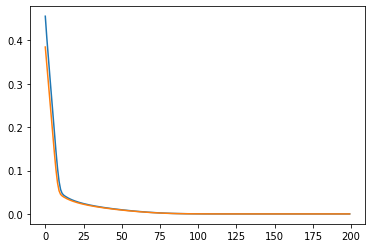

In [235]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.show()

# 8. Test Section

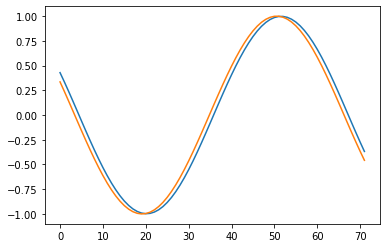

In [236]:

pred = []
for i in range(72):
    test = dataset[i][0]
    test = test.view([1, -1, 1])
    test = test.to(device)
    pred.append(net(test))
    
plt.plot(pred)
plt.plot(y[28:])
plt.show()

In [237]:
test_dataset = DigitDataset('/content/test.csv.zip', transform, train=False)
test_loader = DataLoader(test_dataset, batch_size= batch_size)
y_preds = pred_net(net, test_loader)
submission_df = pd.read_csv('/content/sample_submission.csv', index_col='ImageId')
y_pred_numpy = np.array(y_preds.to('cpu'))
submission_df['Label'] = y_pred_numpy
submission_df
submission_df.to_csv("submission.csv")

NameError: ignored